In [1]:
import numpy as np
np.set_printoptions(precision=3)
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib nbagg

# Constant-Q transform (CQT)

References:

- [(Brown, 1991)](https://asa.scitation.org/doi/abs/10.1121/1.400476)
- [(Schörkhuber and Klapuri, 2010)](https://www.researchgate.net/profile/Christian_Schoerkhuber/publication/228523955_Constant-Q_transform_toolbox_for_music_processing/links/55126aa60cf20bfdad513a3f.pdf)

## Remember how the STFT works

1. Carve the signal into frames of length $n$
2. Apply a window function
3. Compute the FFT of each frame 

    (discard negative frequencies)
   
4. Result: sequence of $\left(1 + \frac{n}{2}\right)$-dimensional frames

## Properties of STFT

- Frequencies are **linearly spaced** from 0 to Nyquist:

In [7]:
librosa.fft_frequencies(8000, n_fft=32)

array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
       2250., 2500., 2750., 3000., 3250., 3500., 3750., 4000.])

In [2]:
librosa.note_to_hz(['C1', 'C#1', 'C5', 'C#5', 'C8', 'C#8'])

array([  32.703,   34.648,  523.251,  554.365, 4186.009, 4434.922])

- **Ratio** between frequencies matters more than **difference**

    in 12-TET, the ratio is $2^{1/12} \approx 1.06$

### Frame length

- Length ($n$) is **constant** for all frequencies

- How many cycles per frame at frequency $f$?

- $f$ (cycles / second)
- $n$ (samples / frame)
- $f_s$ (samples / second)

    $\Rightarrow f \cdot \frac{n}{f_s}$ cycles per frame

### What does $\left(f \cdot \frac{n}{f_s}\right)$ mean for music?

- More cycles per frame $\Leftrightarrow$ sustained tone
- Low frequencies need long windows
- But long windows lose (unsustained) high frequencies


## The Constant-Q transform [(Brown, 1991)](https://asa.scitation.org/doi/abs/10.1121/1.400476)

Two key ingredients:

1. Variable frame lengths
2. Logarithmic frequency scale

### Building the CQT basis

- Specify the desired frequency resolution

    - Usually measured in `bins per octave`

- Fix the number of cycles per frame for all $f$

    - This is the (inverse) $Q$ for quality

- Solve for the frame lengths

### CQT basis example

In [39]:
cq_basis, cq_len = librosa.filters.constant_q(22050,
                                              norm=None,
                                              fmin=32.7,
                                              n_bins=12,
                                              bins_per_octave=12)

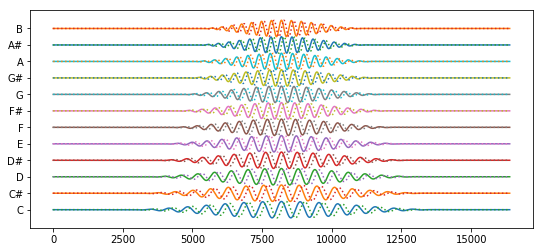

In [40]:
plt.figure(figsize=(9, 4))
plt.plot(cq_basis.T.real + 2 * np.arange(len(cq_basis)))
plt.plot(cq_basis.T.imag + 2 * np.arange(len(cq_basis)), linestyle=':');
plt.yticks(np.arange(0, 24, 2), librosa.midi_to_note(np.arange(12), octave=False));

## Implementing CQT

- Once we have the basis, just convolve with the signal?

- Well...

In [32]:
print('Basis lengths:\n', cq_len)
print('\nPadded basis shape:\n', cq_basis.shape)

Basis lengths:
 [11340.007 10703.542 10102.798  9535.772  9000.57   8495.407  8018.596
  7568.547  7143.757  6742.809  6364.364  6007.16 ]

Padded basis shape:
 (12, 16384)


- 16K samples just to measure *C1*?

- This is incredibly slow in practice

## A clever observation [(Schörkhuber and Klapuri, 2010)](https://www.researchgate.net/profile/Christian_Schoerkhuber/publication/228523955_Constant-Q_transform_toolbox_for_music_processing/links/55126aa60cf20bfdad513a3f.pdf)

- The CQT basis functions have **structure**
    
- Filter $k$ looks like $k/2$ after down-sampling

In [49]:
cq_basis, cq_len = librosa.filters.constant_q(22050, norm=None,
                                              fmin=32.7, n_bins=24,
                                              bins_per_octave=12)

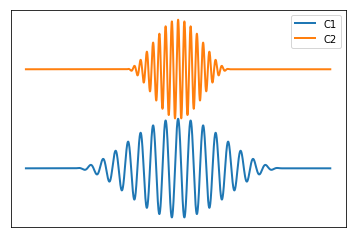

In [50]:
plt.plot(cq_basis[0,].real, linewidth=2, label='C1');

plt.plot(2 + cq_basis[12].real, linewidth=2, label='C2')
plt.xticks([])
plt.yticks([])
plt.legend();

### Recursive downsampling

- Only build the filter bank for the **top octave**

- Approximate response at lower octaves by recursively downsampling **the signal**


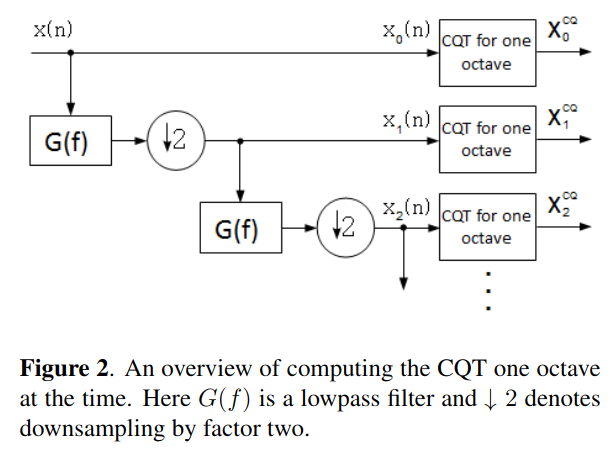

## Why is this cheaper?

- The top octave filters are **small**

In [52]:
lens = librosa.filters.constant_q_lengths(22050, 32.7, 84)
print('Bottom octave lengths:\n\t{}'.format(lens[:12]))
print('Top octave lengths:   \n\t{}'.format(lens[-12:]))

Bottom octave lengths:
	[11340.007 10703.542 10102.798  9535.772  9000.57   8495.407  8018.596
  7568.547  7143.757  6742.809  6364.364  6007.16 ]
Top octave lengths:   
	[177.188 167.243 157.856 148.996 140.634 132.741 125.291 118.259 111.621
 105.356  99.443  93.862]


- Signal length for octave $m$ is $\approx N /2^m$
- Downsampling by 2 is cheap

## Example

In [3]:
y, sr = librosa.load(librosa.util.example_audio_file(), sr=None)

In [21]:
BPO = 12*5
N = 7 * BPO

C = librosa.cqt(y=y, sr=sr, n_bins=N, bins_per_octave=BPO)

In [22]:
librosa.note_to_hz('C#1')

34.64782887210901

In [23]:
librosa.cqt_frequencies(N, librosa.note_to_hz('C1'), bins_per_octave=BPO)

array([  32.703,   33.083,   33.468,   33.856,   34.25 ,   34.648,
         35.05 ,   35.458,   35.87 ,   36.286,   36.708,   37.135,
         37.566,   38.003,   38.444,   38.891,   39.343,   39.8  ,
         40.262,   40.73 ,   41.203,   41.682,   42.167,   42.656,
         43.152,   43.654,   44.161,   44.674,   45.193,   45.718,
         46.249,   46.787,   47.33 ,   47.88 ,   48.437,   48.999,
         49.569,   50.145,   50.727,   51.317,   51.913,   52.516,
         53.126,   53.744,   54.368,   55.   ,   55.639,   56.286,
         56.94 ,   57.601,   58.27 ,   58.948,   59.632,   60.325,
         61.026,   61.735,   62.453,   63.178,   63.913,   64.655,
         65.406,   66.166,   66.935,   67.713,   68.5  ,   69.296,
         70.101,   70.915,   71.739,   72.573,   73.416,   74.269,
         75.132,   76.005,   76.888,   77.782,   78.686,   79.6  ,
         80.525,   81.46 ,   82.407,   83.364,   84.333,   85.313,
         86.304,   87.307,   88.322,   89.348,   90.386,   91.

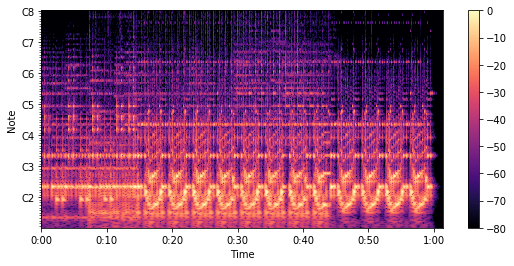

In [18]:
plt.figure(figsize=(9, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(C), ref=np.max),
                         bins_per_octave=BPO, sr=sr,
                         y_axis='cqt_note', x_axis='time')
plt.colorbar();

## CQT Recap

- Acoustically meaningful frequency basis
- Critical parameters:
    - `fmin`
    - `bins_per_octave`
    - `n_bins`
    - And the usual suspects: `sr`, `hop_length`...
- Log-frequency is a good start for convolutional networks...